In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

warnings.filterwarnings("ignore")

In [12]:
base_dir = "C:/Users/natda/Desktop/NatDave/Academics/PhD_NU/RESEARCH/BlueBikes/"

# Load cleaned trip data with engineered features
feature_engineered_path = os.path.join(base_dir, "feature_engineered_trips.csv")
df = pd.read_csv(feature_engineered_path)

# Load station distance matrix
distance_matrix_path = os.path.join(base_dir, "station_distance_matrix.csv")
distance_matrix = pd.read_csv(distance_matrix_path, index_col=0).fillna(0)

Classification Report:



,precision,recall,f1-score,support,AUC
0,0.299023,0.613739,0.402125,226826.000000,0.609254
1,0.811705,0.536464,0.645988,704032.000000,0.609254
accuracy,0.555294,0.555294,0.555294,0.555294,0.609254
macro avg,0.555364,0.575102,0.524057,930858.000000,0.609254
weighted avg,0.686778,0.555294,0.586565,930858.000000,0.609254



Confusion Matrix:

[[139212  87614]
 [326344 377688]]


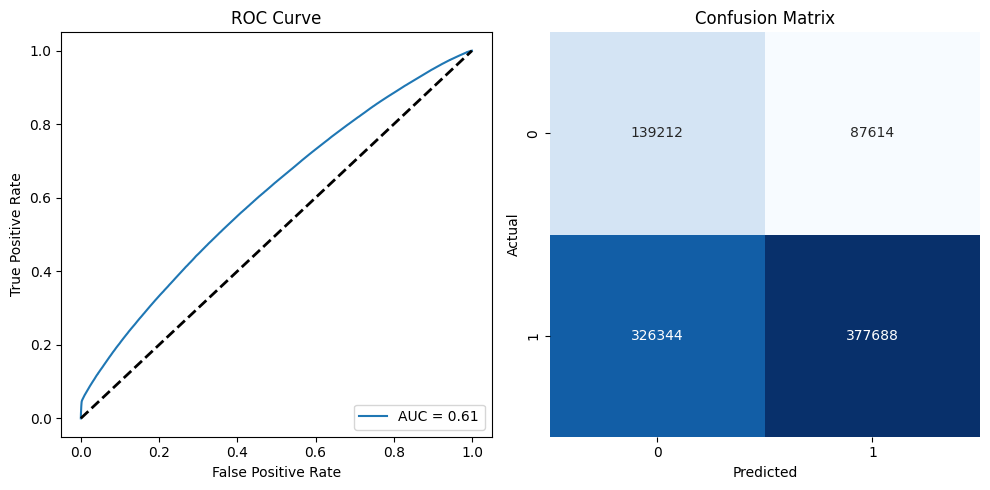

In [13]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
from imblearn.over_sampling import SMOTE
import xgboost as xgb

# Convert started_at and ended_at columns to datetime
df["started_at"] = pd.to_datetime(df["started_at"], errors='coerce')
df["ended_at"] = pd.to_datetime(df["ended_at"], errors='coerce')

# Feature extraction and preprocessing
selected_columns = ['started_at', 'rider_type', 'trip_duration_minutes', 'trip_distance_km', 'bike_type']
df = df[selected_columns].copy()

df['hour_of_day'] = df['started_at'].dt.hour
df['day_of_week'] = df['started_at'].dt.dayofweek
df['month'] = df['started_at'].dt.month
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

X = df.drop(columns=['bike_type', 'started_at'])
y = df['bike_type']

le = LabelEncoder()
X['rider_type'] = le.fit_transform(X['rider_type'].astype(str))
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

num_features = ['trip_duration_minutes', 'trip_distance_km', 'hour_of_day', 'day_of_week', 'month']
cat_features = ['rider_type', 'is_weekend']

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = SimpleImputer(strategy='most_frequent')

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train XGBoost model with optimized hyperparameters
optimized_params = {
    'reg_lambda': 1,
    'reg_alpha': 0.5,
    'max_depth': 6,
    'learning_rate': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'random_state': 42
}

optimized_model = xgb.XGBClassifier(**optimized_params)

# Train the model on the resampled training data
optimized_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = optimized_model.predict(X_test)
y_pred_proba = optimized_model.predict_proba(X_test)[:, 1]

# Evaluate model performance
report = classification_report(y_test, y_pred, output_dict=True)
auc_score = roc_auc_score(y_test, y_pred_proba)

# Display classification report
report_df = pd.DataFrame(report).transpose()
report_df['AUC'] = auc_score

print("Classification Report:\n")
display(report_df)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n")
print(conf_matrix)

# Visualizations
fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=100)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[0].plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
axes[0].plot([0, 1], [0, 1], 'k--', lw=2)
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC Curve")
axes[0].legend(loc="lower right")

# Confusion Matrix Heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[1], cbar=False)
axes[1].set_title("Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

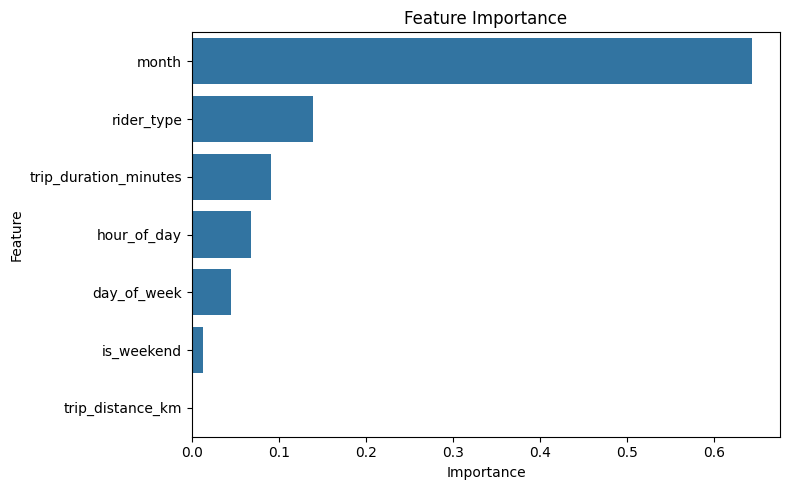

In [14]:
# Plot Feature Importances
importances = optimized_model.feature_importances_
feature_names = num_features + cat_features  # Combine numeric and categorical feature names
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(8, 5), dpi=100)
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()